In [14]:
import os
import sys
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import polars as pl
import numpy as np
from scipy.optimize import minimize
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import stats

100%|██████████| 5/5 [00:00<00:00, 100.29it/s]


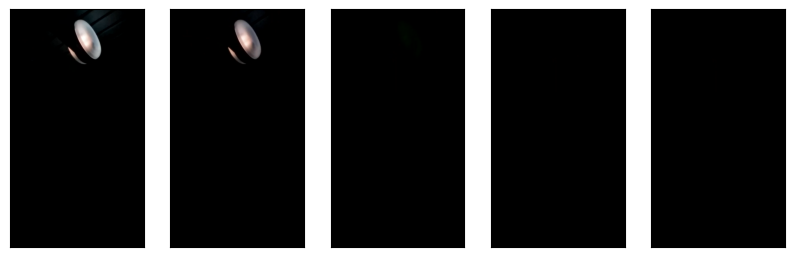

In [2]:
path = './data/frames'
files = os.listdir(path)
files.sort()
imgs = []
for i in tqdm(range(5)):
    img = cv2.imread(os.path.join(path, files[i]))
    imgs.append(img)

fig, ax = plt.subplots(1, 5, figsize=(10, 5))  
for i in range(5):
    ax[i].imshow(imgs[i])   
    ax[i].set_xticks([])  
    ax[i].set_yticks([])

plt.show()  

In [7]:
def process_image(img):
    img = img.astype('float32')
    img /= 255
    img = img.mean(axis=(0, 1, 2))
    return img

values = []
for file in tqdm(files):
    img = cv2.imread(os.path.join(path, file))
    mean = process_image(img)
    img_ind = int(file.split('.')[0].split('-')[1])
    values.append((img_ind, mean))
data = pl.DataFrame(values, schema=['img_ind', 'mean'])

100%|██████████| 6796/6796 [00:50<00:00, 134.44it/s]


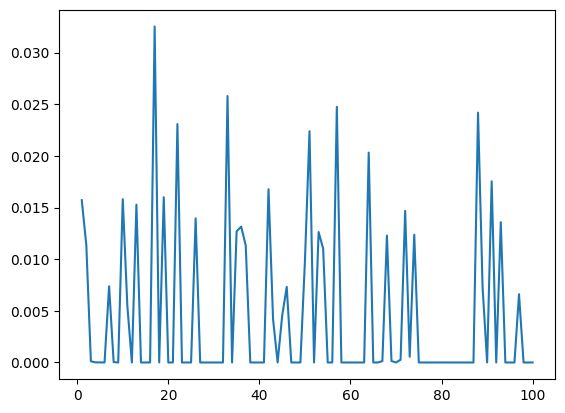

In [8]:
plt.plot(data['img_ind'][:100], data['mean'][:100])
plt.show()

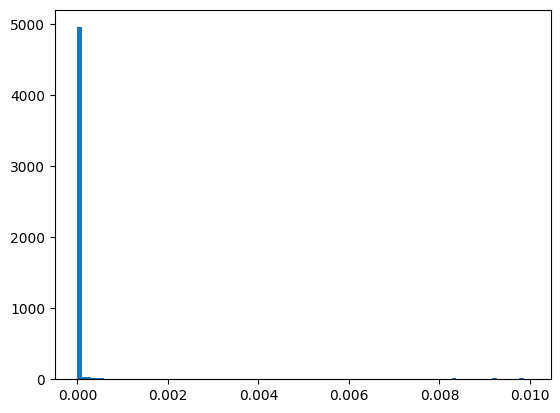

In [9]:
plt.hist(data.filter(pl.col('mean') < 0.01)['mean'], bins=100)
plt.show()

In [10]:
values = []
is_active = False
duration = 0
ind = 0
for file in tqdm(files):
    img = cv2.imread(os.path.join(path, file))
    mean = process_image(img)
    img_ind = int(file.split('.')[0].split('-')[1])
    if mean > 0.002:
        if not is_active:
            ind = img_ind
        is_active = True
        duration += 1
    elif mean <= 0.002 and is_active:
        is_active = False
        values.append((ind, duration))
        duration = 0


100%|██████████| 6796/6796 [00:53<00:00, 127.13it/s]


In [11]:
data = pl.DataFrame(values, schema=['ind', 'duration'])
data = data.with_columns(
    (pl.col('ind').shift(-1).alias('next') - pl.col('ind')).alias('diff')
).with_columns(
    pl.col('diff').shift(-1).alias('next_diff')
)

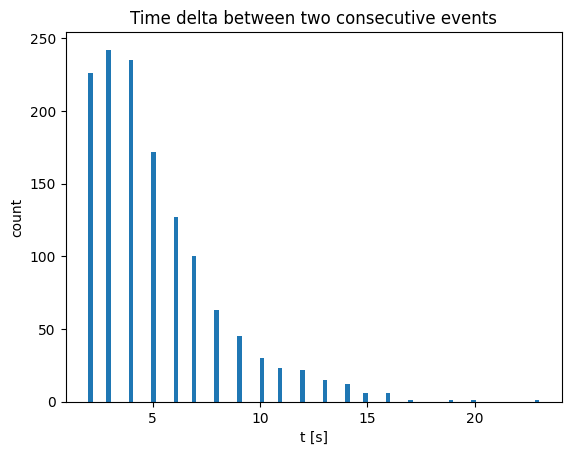

In [18]:
plt.hist(data['diff'], bins=100)
plt.xlabel('t [s]')
plt.ylabel('count')
plt.title('Time delta between two consecutive events')
plt.show()

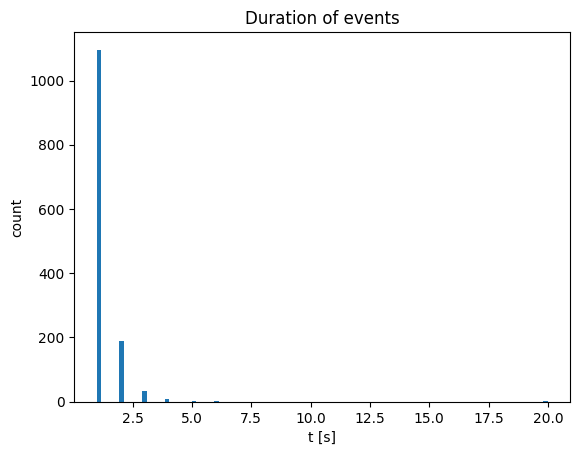

In [19]:
plt.hist(data['duration'], bins=100)
plt.xlabel('t [s]')
plt.ylabel('count')
plt.title('Duration of events')
plt.show()

[6 3 3 ... 3 5 9]
[4 1 1 ... 1 3 7]
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3463.461511470513
             x: [ 3.116e+00]
           nit: 19
          nfev: 38
 final_simplex: (array([[ 3.116e+00],
                       [ 3.116e+00]]), array([ 3.463e+03,  3.463e+03]))


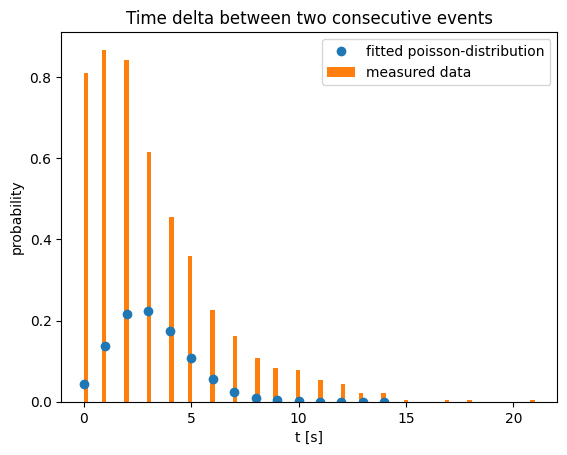

In [20]:
def negative_log_likelihood(params, data):
    """better alternative using scipy"""
    return -stats.poisson.logpmf(data, params[0]).sum()


data_x = data.filter(pl.col("diff").is_not_null())["diff"].to_list()
data_x = np.array(data_x)
print(data_x)
data_x_shifted = data_x - data_x.min()
print(data_x_shifted)

result = minimize(
    negative_log_likelihood,
    x0=np.ones(1),
    args=(data_x_shifted,),
    bounds=((0, None),),
    method="nelder-mead",
)

print(result)

# plot poisson-distribution with fitted parameter
x_plot = np.arange(0, 15)

plt.plot(
    x_plot,
    stats.poisson.pmf(x_plot, result.x),
    marker="o",
    linestyle="",
    label="fitted poisson-distribution",
)
# plot histogram
plt.hist(data_x_shifted, bins=100, density=True, label="measured data")
plt.legend()
plt.xlabel("t [s]")
plt.ylabel("probability")
plt.title("Time delta between two consecutive events")
plt.show()